In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
data = pd.read_csv("covid_19_data_New.csv")

In [4]:
data

,Observation Date,Country,Confirmed,Death,Recovered
0,1/22/2020,China,1.0,0.0,0.0
1,1/22/2020,China,14.0,0.0,0.0
2,1/22/2020,China,6.0,0.0,0.0
3,1/22/2020,China,1.0,0.0,0.0
4,1/22/2020,China,0.0,0.0,0.0
...,...,...,...,...,...
85101,05/25/2021,Afghanistan,66903.0,2836.0,56518.0
85102,05/26/2021,Afghanistan,67743.0,2855.0,56711.0
85103,05/27/2021,Afghanistan,68366.0,2869.0,56962.0
85104,05/28/2021,Afghanistan,69130.0,2881.0,57119.0


In [5]:
# Preprocess the data
data = data.sort_values(by='Observation Date')  # Sort the data by date

In [6]:
# Extract unique countries
countries = data['Country'].unique()

In [7]:
# Normalize the data for each country
scalers = {}
for country in countries:
    country_data = data[data['Country'] == country][['Confirmed', 'Death', 'Recovered']]
    if len(country_data) > 0:
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(country_data)
        data.loc[data['Country'] == country, ['Confirmed', 'Death', 'Recovered']] = scaled_data
        scalers[country] = scaler

In [8]:
# Prepare data for LSTM
sequence_length = 7  # You can adjust this value
X = []
y = []
for country in countries:
    country_data = data[data['Country'] == country][['Confirmed', 'Death', 'Recovered']].values
    for i in range(len(country_data) - sequence_length):
        X.append(country_data[i:i+sequence_length])
        y.append(country_data[i+sequence_length])

X = np.array(X)
y = np.array(y)

In [9]:
# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(units=y.shape[1]))
model.compile(optimizer='adam', loss='mean_squared_error')

F:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0134 - val_loss: 0.0095
Epoch 2/50
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0130 - val_loss: 0.0096
Epoch 3/50
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0132 - val_loss: 0.0097
Epoch 4/50
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0127 - val_loss: 0.0098
Epoch 5/50
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0128 - val_loss: 0.0098
Epoch 6/50
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0127 - val_loss: 0.0100
Epoch 7/50
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0124 - val_loss: 0.0101
Epoch 8/50
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0124 - val_loss: 0.0099
Epoch 9/50
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0120 - val_loss: 0.0100
Epoch 10/50
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0116 - val_loss: 0.0104
Epoch 11/50
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0125 - val_loss: 0.0106
Epoch 12/50
1882/1882 ━━━━━━━━

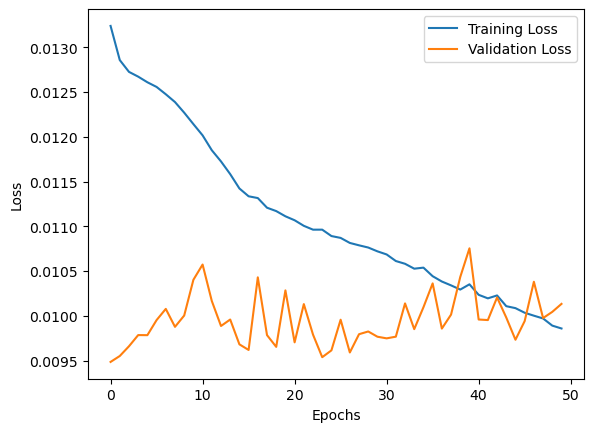

In [12]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train Loss:', train_loss)
print('Test Loss:', test_loss)

Train Loss: 0.009914101101458073
Test Loss: 0.019580133259296417


In [14]:

# Make predictions
y_pred = model.predict(X_test)

523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


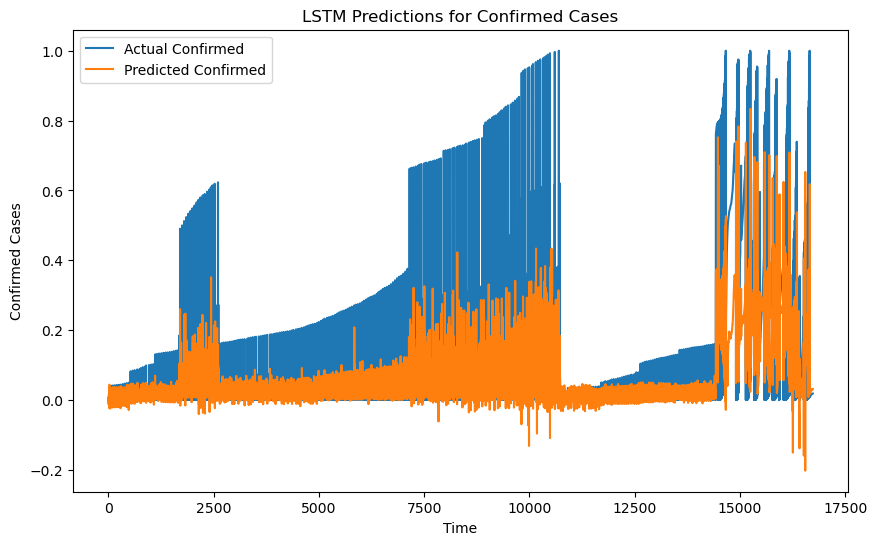

In [15]:
# Plot predictions vs. actuals
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='Actual Confirmed')
plt.plot(y_pred[:, 0], label='Predicted Confirmed')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title('LSTM Predictions for Confirmed Cases')
plt.legend()
plt.show()